### Implementing Differential Privacy

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
from scipy.stats import laplace 
import matplotlib.pyplot as plt

First, let's get more familiar with the [Laplace distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.laplace.html).

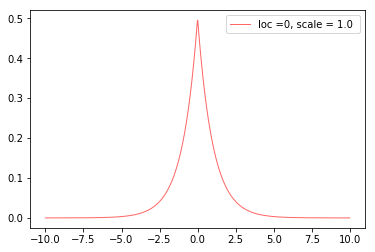

In [3]:
x = np.linspace(-10, 10, 1000 )
y = laplace.pdf(x, 0, 1.0)
plt.plot(x, y,'r-', lw=1, alpha=0.6, label='loc =0, scale = 1.0 ')
plt.legend()



In [5]:
### What does it mean to sample/draw from this distribution?

In [6]:
loc, scale = 0, 1.0
#sample from the laplace
s = laplace.rvs(loc, scale, 1000)
laplace.rvs(loc, scale)

1.237143474065174

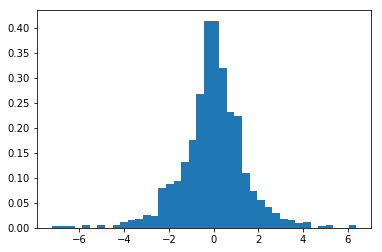

In [7]:
hist= plt.hist(s, 40, normed = True)

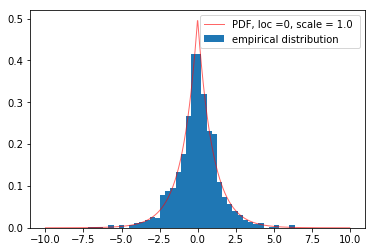

In [8]:
x = np.linspace(-10, 10, 1000 )
y = laplace.pdf(x, loc, scale)
plt.plot(x, y,'r-', lw=1, alpha=0.6, label='PDF, loc =0, scale = 1.0 ')
hist= plt.hist(s, 40, normed = True, label = 'empirical distribution')
plt.legend()

In [9]:
### Let's look at data we're familiar with, from earlier.

In [10]:
data = pd.read_csv('data/compas-scores-two-years.csv', index_col=0)

In [11]:
#filter it out, like before
df = data[(data['days_b_screening_arrest'] <= 30) & (data['days_b_screening_arrest'] >= -30)]

In [19]:
#suppose this is what you'd want to publish in a differentially private manner
output = pd.crosstab(df.v_decile_score, df.sex)
output

sex,Female,Male
v_decile_score,,
1,410,1266
2,196,727
3,158,675
4,140,545
5,107,480
6,60,448
7,51,325
8,28,226
9,22,209


 To each element of the table we'll add noise, sampled from a Laplace distribution. The mean of that noise is 0, and its scale should be enough to drown out the "effect of one individual" on the output.
 
 There is a theorem that says that if the scale of a Laplace distribution is sensitivty/epsilon, then adding noise in the following manner to the output: 
 
 `noisy_output = real_output + noise`
 
 makes the process $\epsilon$-differentially private.

In [14]:
epsilon = 1.0
sensitivity = 1
def laplace_mech(v, sensitivity, epsilon):
    return v + laplace.rvs(loc=0, scale=sensitivity/epsilon)

In [20]:
noisy_output = pd.crosstab(df.v_decile_score, df.sex).applymap(lambda x: laplace_mech(x, 1, epsilon))
noisy_output

sex,Female,Male
v_decile_score,,
1,410.719166,1265.411236
2,194.224062,727.199632
3,156.682187,669.638896
4,139.138510,544.853780
5,105.687799,481.686933
6,60.173627,448.126499
7,50.880063,325.524675
8,27.777997,226.823659
9,19.136960,209.119260


In [24]:
output.subtract(noisy_output, fill_value=0)

sex,Female,Male
v_decile_score,,
1,-0.719166,0.588764
2,1.775938,-0.199632
3,1.317813,5.361104
4,0.861490,0.146220
5,1.312201,-1.686933
6,-0.173627,-0.126499
7,0.119937,-0.524675
8,0.222003,-0.823659
9,2.863040,-0.119260
